In [1]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script to run and export ISSM relaxation
# Mikayla Pascual 07/13/22
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#import 
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

import lhsmdu #install in terminal 'pip install lhsmdu'
import matplotlib.pyplot as plt
import pickle



could not import shapefile, PyShp has not been installed, no shapefile reading capabilities enabled


In [2]:
region = 'SAtoES'
start_year = 1985.

Opening ./Models/SAtoES_inversion.nc for reading 
solidearthsettings.solidearthsettings
lovenumbers.lovenumbers
rotational.rotational
results.solutionstep
empty init


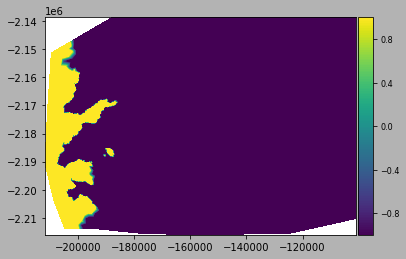

In [3]:
md = loadmodel('./Models/SAtoES_inversion.nc')
#plotmodel(md, 'data', md.mask.ice_levelset)
md.levelset.spclevelset = np.nan * np.ones((md.mesh.numberofvertices))
pos = md.mesh.vertexonboundary == 1
#pos = np.where(md.mesh.vertexonboundary)
md.levelset.spclevelset[pos] = md.mask.ice_levelset[pos]
md.levelset.migration_max = 1e10
plotmodel(md, 'data', md.mask.ice_levelset)

In [4]:
## Relaxation
#Put results of inversion back into the model for forward runs
md.friction.coefficient=md.results.StressbalanceSolution.FrictionCoefficient
relaxation_years = 1 #try 5 years if 1 runs quickly

# Special post-processing of inverted friction coefficient
filename = 'Exp/' +region+ '_coeffront_after_inversion.exp'
if os.path.isfile(filename):
  pos = find(ContourToNodes(md.mesh.x, md.mesh.y, filename, 1))
  md.friction.coefficient[pos] = 10

md.initialization.pressure = np.zeros([md.mesh.numberofvertices,1])
md.initialization.temperature = 250*np.ones([md.mesh.numberofvertices,1])

# Set parameters
md.inversion.iscontrol=0;
md.timestepping.start_time = start_year;
md.timestepping.time_step  = .02;
md.timestepping.final_time = start_year + relaxation_years;
md.settings.output_frequency = (1/md.timestepping.time_step)/5; # 5/yr

In [5]:
with open('ens_dict.pickle', 'rb') as f:
    ens_data = pickle.load(f)

In [6]:
md.calving

   Calving parameters:         calvingrate            : N/A             -- calving rate at given location [m/a]

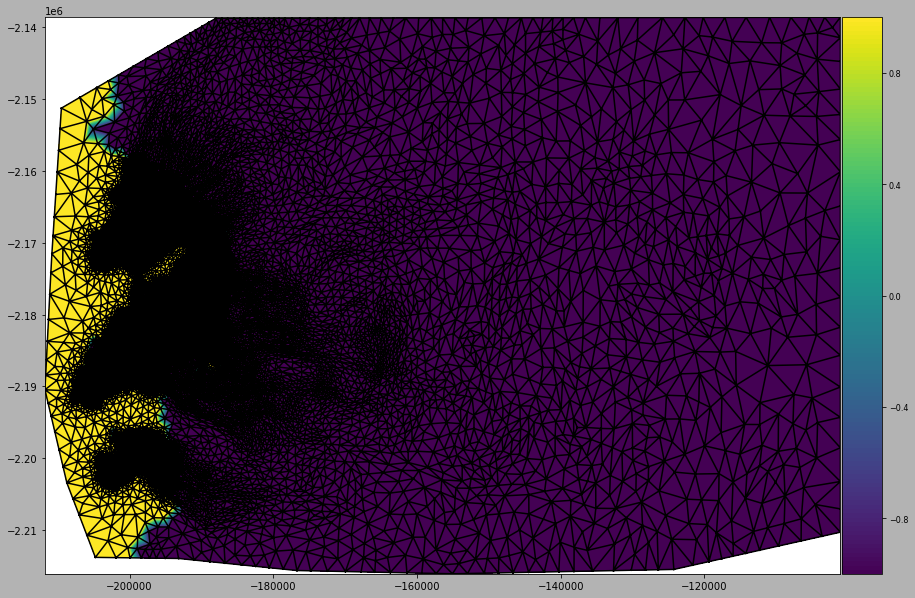

In [9]:
fig = plt.figure(figsize=(15,15))
plotmodel(md, 'data', md.mask.ice_levelset, 'edgecolor', 'k')

#plt.xlim(-215000, -190000)
#plt.ylim(-2210000, -2170000)

(-2210000.0, -2170000.0)

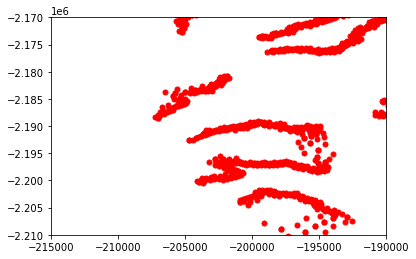

In [10]:
# code added 8/3/22, 
n_buffer = 2
for i in range(n_buffer):
    elements = md.mesh.elements.astype(int)-1
    nodes_edge = elements[np.where(np.sum(md.mask.ice_levelset[elements] == -1, axis=1) == 2)[0]]
    nodes_edge = np.unique(nodes_edge.ravel())
    nodes_bed = np.where(md.geometry.bed > 0)[0]
    nodes_edge_bed = np.array(list(set(nodes_edge) & set(nodes_bed)))
    plt.plot(md.mesh.x[nodes_edge_bed], md.mesh.y[nodes_edge_bed], 'r.', markersize=10)

    md.mask.ice_levelset[nodes_edge_bed] = -1
    md.geometry.thickness[nodes_edge_bed] = 10
    md.geometry.surface[nodes_edge_bed] = md.geometry.bed[nodes_edge_bed] + md.geometry.thickness[nodes_edge_bed]

    md.friction.coefficient[nodes_edge_bed] = 200

In [11]:
#for ensemble_ID in ens_data.keys():
ensemble_ID = 'Trial9' # change ID for each Trial value
subglacial_discharge = ens_data[ensemble_ID]['sd_after']
thermal_forcing = ens_data[ensemble_ID]['tf_after']
calving = ens_data[ensemble_ID]['calve_after']

#print(ensemble_ID)
#print(subglacial_discharge)
#print(thermal_forcing)
#print(calving)
#continue

# We set the transient parameters
md.transient.ismovingfront=1
md.transient.isthermal=0
md.transient.isstressbalance=1
md.transient.ismasstransport=1
md.transient.isgroundingline=1
md.groundingline.migration = 'SubelementMigration'

# We set the ocean conditions
from frontalforcingsrignot import frontalforcingsrignot
md.frontalforcings = frontalforcingsrignot()

#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
md.frontalforcings.subglacial_discharge = 2.6 * np.ones(md.mesh.numberofvertices) + subglacial_discharge #add LHS value
md.frontalforcings.thermalforcing = 15.7 * np.ones(md.mesh.numberofvertices) + thermal_forcing #add LHS value
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

md.frontalforcings.basin = 1 * np.ones(md.mesh.numberofvertices)
md.frontalforcings.numberofbasins = 1

# We set the calving model (no moving front ... spclevelset is actually ignored)
from calvingvonmises import calvingvonmises
md.calving = calvingvonmises()

#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
md.calving.stress_threshold_groundedice = calving #replace with LHS value
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#md.levelset.spclevelset = np.nan * np.ones([md.mesh.numberofvertices,1])
#md.calving.calvingrate = np.zeros([md.mesh.numberofvertices,1])
#md.frontalforcings.meltingrate = np.zeros([md.mesh.numberofvertices,1])
#md.calving.meltingrate = np.ones([md.mesh.numberofvertices,1])

# Set the requested outputs
md.stressbalance.requested_outputs=['default']
md.transient.requested_outputs=['default','IceVolumeAboveFloatation']

# Go solve
md.verbose.solution=1
md.cluster = generic()
md.settings.waitonlock = np.inf
md = solve(md,'transient')

from export_netCDF import export_netCDF

md.inversion.cost_functions = md.inversion.cost_functions.astype(np.float64)
for i in range(len(md.results.TransientSolution)):
    md.results.TransientSolution[i].step = np.float64(md.results.TransientSolution[i].step)

export_netCDF(md, "./Models/SAtoES_relaxation_" +ensemble_ID+ ".nc")

checking model consistency
marshalling file SAtoES.bin
uploading input file and queueing script
launching solution sequence on remote cluster
cd /efs/issm/issm/trunk-jpl-denis/execution && rm -rf ./SAtoES-08-03-2022-21-46-48-315 && mkdir SAtoES-08-03-2022-21-46-48-315 && cd SAtoES-08-03-2022-21-46-48-315 && mv ../SAtoES-08-03-2022-21-46-48-315.tar.gz ./&& tar -zxf SAtoES-08-03-2022-21-46-48-315.tar.gz  && chmod 755 SAtoES.queue && ./SAtoES.queue

Ice Sheet System Model (ISSM) version  4.19
(website: http://issm.jpl.nasa.gov contact: issm@jpl.nasa.gov)

call computational core:
iteration 1/50  time [yr]: 1985 (time step: 0.02)
   computing smb 
   computing new velocity
   computing calving and undercutting
   computing new ice front position
   computing slope of levelset function...
   extrapolation of Vx:
   extrapolation of Vy:
   extrapolation of Thickness:
   call computational core:
   looking for icebergs to kill
   computing basal mass balance
   computing mass transport
   cal

Give a new name or "delete" to replace:  delete


field md.solidearth.external is None
qmu is skipped until it is more stable


In [12]:
md = loadmodel('./Models/SAtoES_relaxation_Trial9.nc')

Opening ./Models/SAtoES_relaxation_Trial9.nc for reading 
solidearthsettings.solidearthsettings
lovenumbers.lovenumbers
rotational.rotational
results.results
results.solutionstep
empty init
WARNING, StressbalanceConvergenceNumSteps is not present on every times, we chose DimNum10(1) as the dimension to write it with


In [13]:
md.results.TransientSolution

  1x6 struct array with fields:

    StressbalanceConvergenceNumSteps
    step
    time
    Vel
    Pressure
    Vx
    Vy
    MaskIceLevelset
    Thickness
    Surface
    Base
    MaskOceanLevelset
    SmbMassBalance
    IceVolumeAboveFloatation
    SolutionType

In [14]:
md.results.TransientSolution[5].MaskIceLevelset

array([-1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
        1.03503589e+01, -1.14810554e+03, -1.08149283e+05])

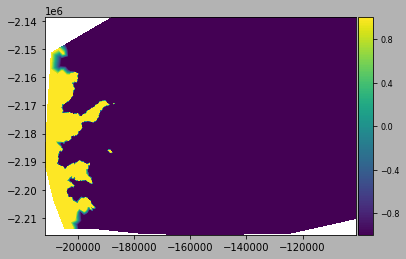

In [15]:
plotmodel(md, 'data', np.array(md.mask.ice_levelset))

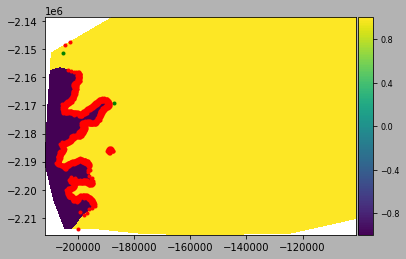

In [16]:
time = [md.results.TransientSolution[i].time for i in range(len(md.results.TransientSolution))]
VAF = [md.results.TransientSolution[i].IceVolumeAboveFloatation for i in range(len(md.results.TransientSolution))]

# Look for terminus advance
idx = np.logical_and(np.array(md.mask.ice_levelset) > 0, \
                     np.array(md.results.TransientSolution[5].MaskIceLevelset).ravel() <= 0)
pos_advance = np.where(idx)[0]

# Look for terminus retreat
idx = np.logical_and(np.array(md.mask.ice_levelset) < 0, \
                     np.array(md.results.TransientSolution[5].MaskIceLevelset).ravel() >= 0)
pos_retreat = np.where(idx)[0]

#fig = plt.figure(figsize=(10,10))
#plotmodel(md, 'data', np.array(md.mask.ice_levelset), \
#              'data', np.array(md.results.TransientSolution[5].MaskIceLevelset).ravel(), \
#              'caxis#all', [-1., +1.])
plotmodel(md, 'data', np.array(md.mask.ice_levelset) - np.array(md.results.TransientSolution[4].MaskIceLevelset).ravel(), \
              'caxis#all', [-1, +1])

plt.plot(md.mesh.x[pos_advance], md.mesh.y[pos_advance], 'g.')
plt.plot(md.mesh.x[pos_retreat], md.mesh.y[pos_retreat], 'r.')

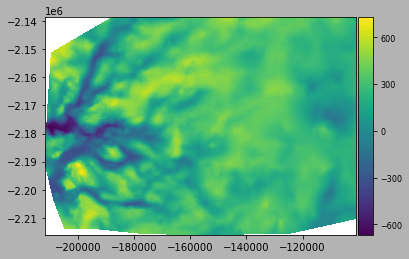

In [16]:
plotmodel(md,'data', md.geometry.bed)

In [17]:
md.levelset

   Level-set parameters:
         stabilization          : 1               -- 0: no, 1: artificial_diffusivity, 2: streamline upwinding
         spclevelset            : (12112,)        -- Levelset constraints (NaN means no constraint)
         reinit_frequency       : 5               -- Amount of time steps after which the levelset function in re-initialized
         kill_icebergs          : 1               -- remove floating icebergs to prevent rigid body motions (1: true, 0: false)
         migration_max          : 10000000000.0   -- maximum allowed migration rate (m/a)
         fe                     : 'P1'            -- Finite Element type: 'P1' (default), or 'P2'

IndexError: arrays used as indices must be of integer (or boolean) type

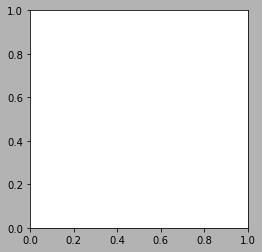

In [12]:
plotmodel(md, 'data', 'BC')

In [10]:
md.results.TransientSolution[5].MaskIceLevelset

array([[-16710.24741481],
       [  5284.22963663],
       [  4062.45684144],
       ...,
       [  -812.40708016],
       [ -1777.59417679],
       [-89056.42866602]])

In [25]:
md.calving

   Calving VonMises parameters:
         stress_threshold_gro...: 500000.0        -- sigma_max applied to grounded ice only [Pa]
         stress_threshold_flo...: 150000.0        -- sigma_max applied to floating ice only [Pa]
         min_thickness          : 0.0             -- minimum thickness below which no ice is allowed [m]